-----------

This notebook covers two algorithms I developed to generate adversarial examples that avoid detection by the trapdoor defense from Shan el al 2020.

The first uses the outcome of an initial pass of projected gradient descent and adds a term measuring distance to this example to the loss function in an attempt to bias the algorithm away from the trapdoor, which is likely to provide the steepest descent in the loss function.

The second reduces the largest elements of the gradient before applying PGD, assuming that these largest elements are likely to lead towards the trapdoor.

-----------

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
from tensorflow.keras.datasets import cifar10

import cifar10_bd_train
import backdoor_utils
import targeted_pgd

In [2]:
plt.style.use('seaborn-whitegrid')

In [3]:
def plot_pos_rates(plot_data, labels):
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    plt.figure(figsize=[10.0, 10.0])
    th = [i for i in range(90, 100)]
    i = 1
    for label in labels:
        plt.subplot(2, 2, i)
        t_pos_arr, f_pos_arr = plot_data[label]
        plt.plot(th, t_pos_arr, '-ok', label='true_pos_rate')
        plt.plot(th, f_pos_arr, 'b--', label='false_pos_rate')
        plt.title('Model Defending Label ' + str(label))
        plt.xlim(90, 100)
        plt.ylim(0.0, 1.0)
        plt.legend();
        i += 1

-------------

Load, unpack, and preprocess data

-------------

In [4]:
raw_train_data, raw_test_data = cifar10.load_data()

In [5]:
raw_train_images, raw_train_labels = raw_train_data
raw_test_images, raw_test_labels = raw_test_data

train_images, train_labels = cifar10_bd_train.preprocess(raw_train_images, raw_train_labels)
test_images, test_labels = cifar10_bd_train.preprocess(raw_test_images, raw_test_labels)

--------------

Load models and backdoor patterns for randomly initialized trigger locations and bottom-right located triggers.

--------------

In [6]:
# load randomly initialized
labels = [2, 3, 5, 7]
models_basic = {}
for label in labels:
    fp = 'cifar10_hp_nonoise/label' + str(label) + 'noise0.0'
    model = tf.keras.models.load_model(fp)
    pattern = np.load(fp + '/pattern.npy')
    mask = np.load(fp + '/mask.npy')
    models_basic[label] = (model, pattern, mask)

In [7]:
# load bottom right initialized
labels = [2, 3, 5, 7]
models_botRight = {}
for label in labels:
    fp = 'cifar10_hp_nonoise/label' + str(label) + 'noise0.0bottomRight'
    model = tf.keras.models.load_model(fp)
    pattern = np.load(fp + '/pattern.npy')
    mask = np.load(fp + '/mask.npy')
    models_botRight[label] = (model, pattern, mask)

------------------

### Gradient Probe Attack
First attempt is to try to avoid the trapdoor with a gradient probe attack.  This algorithm first calculates a projected gradient descent attack step, then uses the resulting image in a new loss function that combines the crossentropy loss to the target class with a term representing the distance between the image being optimized and the image that was found in the PGD step. 

The intuition of the algorithm was to use the first PGD step as a probe, assuming that the preferred direction at each step would lead towards the trapdoor.  This probe image is then incorporated into the loss to incentivize finding an adversarial example without taking the same path as the probe.

------------------

In [8]:
from targeted_pgd import gradient_probe_attack
from targeted_pgd import gradient_mask_reduc_attack
from backdoor_utils import sim_distribution
from backdoor_utils import inject_backdoor_pattern
from backdoor_utils import build_backdoor_sig
from backdoor_utils import test_backdoor_defense

from backdoor_utils import setup_backdoor_defense

-------------

Evaluation on randomly initialized backdoor models.  Values for the attack were found from random experimentation.  Grid search would likely find more effective values, but time considerations prevented doing that in this study.  Even so, the attack is somewhat effective, in some cases greatly reducing the ability of the detection method to identify the attacks.

eps = constraint on distance from original image

lam = weight on the distance term of the adjusted loss function

beta = step size for probe image

alpha = step size for final image

-------------

In [9]:
labels = [2, 3, 5, 7]
plot_data = {}

for label in labels:
    model, pattern, mask = models_basic[label]
    sig, feature_extractor, thresholds = setup_backdoor_defense(label, model, pattern,
                                                       mask, test_images,
                                                       train_images, raw_train_labels)
#     imgs, loss = gradient_probe_attack(model, test_images, label, 2000,
#                                        steps=50, alpha=0.0001, beta=0.03,
#                                        eps=0.03, lam=0.996)
    
    fp = 'cifar10_hp_nonoise/label'+str(label)+'noise0.0/attacks/GradientProbe/'
#     if not os.path.exists(fp):
#         os.makedirs(fp)
#     np.save(fp + 'imgs', imgs)
#     np.save(fp + 'loss', loss)
        
    imgs = np.load(fp + 'imgs.npy')
    loss = np.load(fp + 'loss.npy')
    
    plot_data[label] = test_backdoor_defense(imgs, test_images, label, feature_extractor, sig, thresholds)

<Figure size 432x288 with 0 Axes>

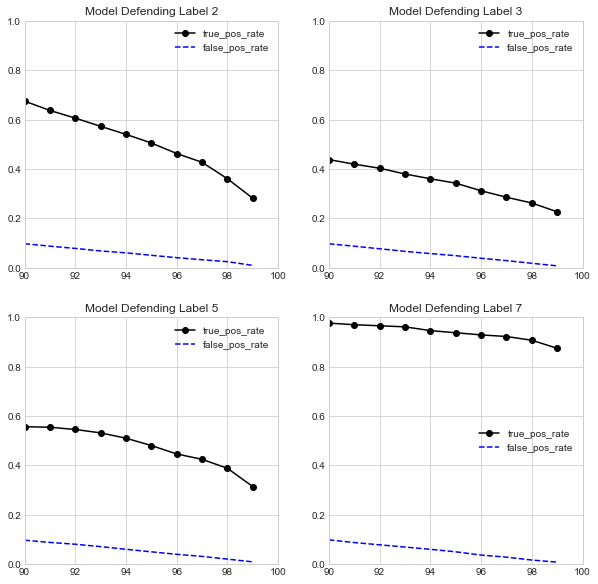

In [10]:
plot_pos_rates(plot_data, labels)

-------------

Evaluation on bottom right corner triggered models.  The algorithm has a harder time finding successful adversarial examples for this model.  The detection accuracy of the models is significantly lower than with basic PGD.

The settings used were the result of tuning parameters to the set of random tigger placement models.  The attack success rate could likely be improved by tuning parameters to the set of bottom right triggered models.

-------------

In [11]:
labels = [2, 3, 5, 7]
plot_data = {}

for label in labels:
    model, pattern, mask = models_botRight[label]
    
    sig, feature_extractor, thresholds = setup_backdoor_defense(label, model,
                                                                pattern, mask,
                                                                test_images,
                                                                train_images,
                                                                raw_train_labels)
#     imgs, loss = gradient_probe_attack(model, test_images, label, 2000,
#                                        steps=50, alpha=0.0001, beta=0.03,
#                                        eps=0.03, lam=0.996)
    
    fp = 'cifar10_hp_nonoise/label'+str(label)+'noise0.0bottomRight/attacks/GradientProbe/'
#     if not os.path.exists(fp):
#         os.makedirs(fp)
#     np.save(fp + 'imgs', imgs)
#     np.save(fp + 'loss', loss)

    imgs = np.load(fp + 'imgs.npy')
    loss = np.load(fp + 'loss.npy')
    
    plot_data[label] = test_backdoor_defense(imgs, test_images, label, feature_extractor, sig, thresholds)

<Figure size 432x288 with 0 Axes>

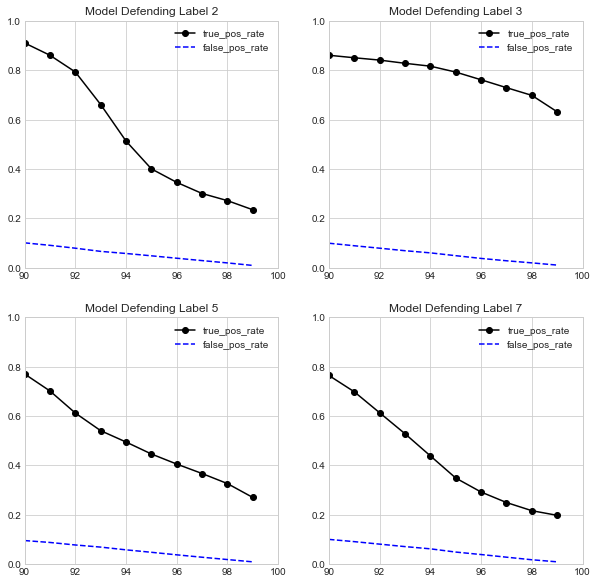

In [12]:
plot_pos_rates(plot_data, labels)

---------------

### Gradient Mask Reduction Attack
Another attack which attempts to avoid the trapdoors.  The gradient mask reduction attack reduces all values in the gradient with magnitude over a threshold by a predetermined ratio.  The threshold is specified as a percentage of the largest magnitude in the gradient.

The original paper notes that backdoors introduce a highly effective path to misclassification.  This algorithm assumes that this highly effective path will show up as unusually large values in the gradient, and so reducing the contribution of these unusually large values may help avoid converging to the trapdoor.

---------------

In [13]:
from targeted_pgd import gradient_probe_attack
from targeted_pgd import gradient_mask_reduc_attack

In [14]:
labels = [2, 3, 5, 7]
plot_data = {}

for label in labels:
    model, pattern, mask = models_basic[label]
    
    sig, feature_extractor, thresholds = setup_backdoor_defense(label, model,
                                                                pattern, mask,
                                                                test_images,
                                                                train_images,
                                                                raw_train_labels)
#     imgs, loss = gradient_mask_reduc_attack(model, test_images, label, 2000,
#                                        steps=50, alpha=0.00006, eps=0.05,
#                                        lam=0.95, thresh=0.992)
    
    fp = 'cifar10_hp_nonoise/label'+str(label)+'noise0.0/attacks/GradientMaskReduc/'
#     if not os.path.exists(fp):
#         os.makedirs(fp)
#     np.save(fp + 'imgs', imgs)
#     np.save(fp + 'loss', loss)

    imgs = np.load(fp + 'imgs.npy')
    loss = np.load(fp + 'loss.npy')
    
    plot_data[label] = test_backdoor_defense(imgs, test_images, label, feature_extractor, sig, thresholds)

<Figure size 432x288 with 0 Axes>

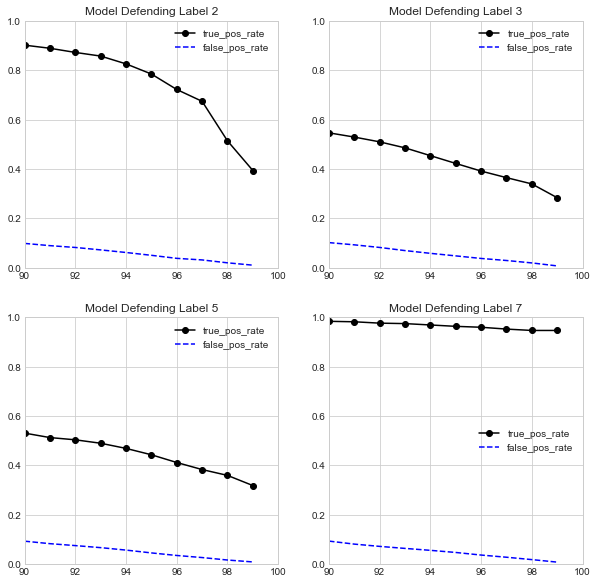

In [15]:
plot_pos_rates(plot_data, labels)

In [16]:
labels = [2, 3, 5, 7]
plot_data = {}

for label in labels:
    model, pattern, mask = models_botRight[label]
    
    sig, feature_extractor, thresholds = setup_backdoor_defense(label, model,
                                                                pattern, mask,
                                                                test_images,
                                                                train_images,
                                                                raw_train_labels)
#     imgs, loss = gradient_mask_reduc_attack(model, test_images, label, 2000,
#                                        steps=50, alpha=0.00006, eps=0.05,
#                                        lam=0.95, thresh=0.992)
    
    fp = 'cifar10_hp_nonoise/label'+str(label)+'noise0.0bottomRight/attacks/GradientMaskReduc/'
#     if not os.path.exists(fp):
#         os.makedirs(fp)
#     np.save(fp + 'imgs', imgs)
#     np.save(fp + 'loss', loss)

    imgs = np.load(fp + 'imgs.npy')
    loss = np.load(fp + 'loss.npy')
    
    plot_data[label] = test_backdoor_defense(imgs, test_images, label, feature_extractor, sig, thresholds)

<Figure size 432x288 with 0 Axes>

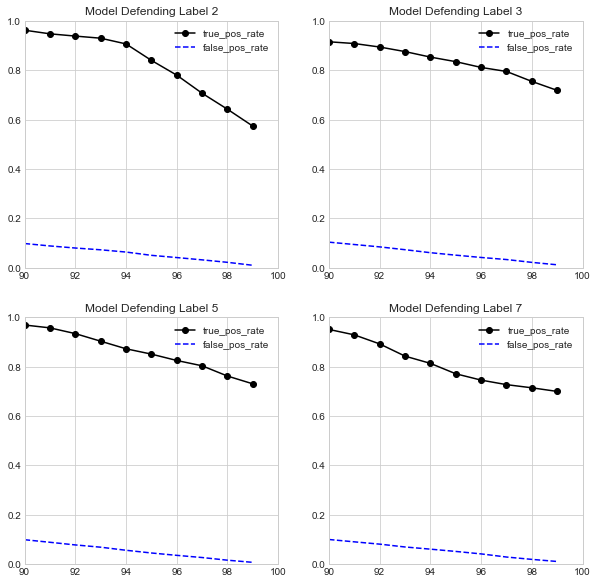

In [17]:
plot_pos_rates(plot_data, labels)

## Ongoing and Future Work

So far I've only been able to use these algorithms bluntly.  I'm beginning work on framing them analytically with the hope that it will help reveal when and how they are effective.  Grid search of the most important parameters can help illuminate the workings of these two algorithms as well.

Additionally, they need to be tested on more datasets and with a larger pool of models.  The effect of trapdoor placement seems to be a large factor, and so testing these algorithms on many models with different trigger placements might help reveal when and how the algorithms work.  